In [59]:
import os
from dotenv import load_dotenv
from pathlib import Path

env_path = Path.cwd().parent / ".env"

load_dotenv(dotenv_path=env_path, override=True)

os.environ["LANGSMITH_PROJECT"] = "wellbeing_assistant"

In [60]:
os.environ["LANGSMITH_PROJECT"]

'wellbeing_assistant'

In [61]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.messages import get_buffer_string
from IPython.display import Image, display
from typing_extensions import TypedDict
from typing import List, Literal 
from pydantic import BaseModel, Field



In [62]:
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

In [63]:
class Step(BaseModel):
    theme: str = Field(
        description="A theme which could be explored to improve the person's wellbeing in the context of the problem that they presented."
        )
    helpful_tip: str = Field(
        description="A piece of advice which follows the theme."
    )

    @property
    def step_summary(self) -> str:
        return f"Theme: {self.theme}\n\nHelpful tip: {self.helpful_tip}"

class Steps(BaseModel):#
    steps : List[Step] = Field(
        description="A list of steps which could be taken to improve user's wellbeing"
    )

class AdvicePlanningState(MessagesState):
    problem: str # problem reported by a user
    plan: str # a wellbeing action plan that has been approved by the user
    steps: List[Step] # a list of selected steps in the wellbeing action plan
    max_steps: int # maximum number of steps in the wellbing action plan
    max_cycles : int # maximum number of allowed |ai_feedback| -> |advice_planner| cycles
    cycles_counter : int # for tracking the cycles
    user_feedback : bool # if user provided a feedback to work on

class PlanningOutputState(TypedDict):
    problem: str # problem reported by a user
    steps: List[Step] # a list of selected steps in the wellbeing action plan
                       

In [64]:
advice_planner_instructions = """# Identity and objectives: 

You are a wellbeing advisor tasked with planning a wellbeing action plan for a user. In doing so, you will be receiving a critical feedback from an another expert and the user. 

Below you will find your conversation with the expert and the user.

# Follow these instructions carefully:

1. First, review the problem reported by the user:

{problem}

2. Review the current state of the conversation.
3. Examine any optional feedback that has been provided by the expert in the conversation.      
4. Examine any optional feedback that has been provided by the user in the conversation. 
5. Preserve as unchanged those themes from the plan for which the expert and the user did not provide a critical feedback (didn't ask to delete or change).
6. Plan up to {max_steps} steps (including the preserved ones) that could be taken to improve the user's wellbeing. 
7. Each step should have its theme. Examples of themes (domains) for those steps include: 
- home remedies,
- conventional medicine,
- lifestyle changes,
- exercises,
- therapy,
- workplace adjustments, 
- other themes (domains) that fit the problem reported by the user.
8. In addition to the theme, each step should be accompanied with one helpful tip (one or two sentences). 
8. You can provide up to three different tips for the same theme, but make sure to assign them to a separate instance of the theme.
9. Here is an example of the expected wellbeing action plan:

"Here is the wellbeing action plan:

- Step -
Theme: Lifestyle changes 
Helpful tip: Improving sleep quality can be effectively achieved by minimising exposure to blue light emitted by electronic devices, particularly in the hours leading up to bedtime.

- Step -
Theme: ...
Helpful tip: ..."

10. Always try to improve the plan based on the feedback from both the user and the expert. If you think the plan cannot be improved any further, output the best version.
11. Don't assume the role of the feedback provider. You are working on the feedback provided.
"""

def advice_planner(state: AdvicePlanningState):
    """Advice-planning node"""
    
    cycles_counter = state.get("cycles_counter", -1)
    user_feedback = state.get("user_feedback", False)
    
    if user_feedback: 
        cycles_counter = -1 # reset the counter if user feedback was provided
        user_feedback = False # reset to False

    problem = state["problem"]
    conversation = state.get("messages", [])
    max_steps = state["max_steps"]
 
    sys_message =  advice_planner_instructions.format(
        problem=problem,
        max_steps=max_steps
    )

    # Messages list
    messages = [
        SystemMessage(content=sys_message),
        AIMessage(content=f"Plan the wellbeing action plan for the user")
    ]
    
    # Trim the conversation if necessary
    if len(conversation) > 5:
        conversation = conversation[-5:]

    plan = llm.invoke(messages + conversation)

    # increment the counter
    cycles_counter += 1

    return {
        "messages" : [plan], 
        "plan" : plan.content,
        "cycles_counter" : cycles_counter,
        "user_feedback" : user_feedback
        }


In [ ]:
feedback_instructions = """# Identity and objectives: 

You are an expert at providing critical feedback for wellbeing action plans.

# Follow these instructions carefully:

1. First, review the problem reported by the user:

{problem}

2. Review the current version of the plan (below) that has been drafted to provide wellbeing support for the user.        
3. Bear in mind that each step in the plan is intentionally kept short. All steps have their theme and are accompanied with a single helpful tip. 
4. When evaluating the current wellbeing action plan, consider these points:
- Is the plan relevant to the the user's problem?
- Considering the user's situation, are those helpful tips really helpful? 
- Are the themes in the plan diverse enough so that they approach the user's problem from different angles?
- All helpful tips should be realistic and pragmatic.
- Your feedback should be critical but constructive and actionable. 

Example of your feedback:

"Providing feedback for the following steps in the wellbeing action plan:

- Step - 
Theme: Exercises
Helpful tip: Regular running can help reduce stress and improve overall mental wellbeing.

My feedback: The explored theme is relevant as exercises can lower stress levels; however, running can not be apropriate for individuals with mobility issues. I suggest a gentler alternative, such as yoga or pilates.

- Step - 
Theme: ...
Helpful tip: ..."

4. ONLY output feedback for those steps that could use additional work. 
5. CRUCIAL: If you believe no further changes to whole plan are required, output "No changes required for the plan". 
6. NEVER output revised version of the plan. Your feedback should limit to the specific steps (as seen in the example).
7. IMPORTANT: The plan shouldn't suggest it is a medical advice.
8. Do NOT repeat your previous feedback. If you have nothing else to add, just output "No changes required for the plan".  

"""

def feedback_generator(state : AdvicePlanningState):
    """Node providing feedback for the advice_planner."""

    problem = state['problem']
    conversation = state['messages']
    
    sys_message =  feedback_instructions.format(problem=problem)

    # Trim the conversation if necessary
    if len(conversation) > 5:
        conversation = conversation[-5:]

    feedback = llm.invoke([SystemMessage(content=sys_message)] + conversation)

    return {'messages': [feedback]}


def continue_planning(state : AdvicePlanningState):
    """Route based on the feedback from the feedback_generator node and completed |feedback| -> |planning| cycles"""

    cycles_counter = state['cycles_counter']
    max_cycles = state.get('max_cycles', 1) # defaults to 1 full |feedback| -> |planning| cycle
    
    if "No changes required for the plan" in state["messages"][-1].content or cycles_counter >= max_cycles:
        return "human_feedback"
    else:
        return "advice_planner"
    
    
def human_feedback(state : AdvicePlanningState):
    """Human feedback node"""

    plan = state["plan"]

    user_feedback = interrupt(f"\n\n---\n\nDo you have any feedback for the current version of the wellbeing action plan? Type 'No feedback' if none.\n\n{plan}")
    
    if user_feedback =="No feedback":
        return {"user_feedback" : False}
    else:
        feedback_formatted = f"My (user) feedback:\n\n{user_feedback}"
        return {
            "user_feedback" : True, 
            "messages" : [HumanMessage(content=feedback_formatted, name="user")]
            }
    
    
def act_on_feedback(state : AdvicePlanningState):
    """Route based on human feedback"""    

    user_feedback = state["user_feedback"]

    # If further work is required
    if user_feedback:
        return "advice_planner"
    else:
        return "format_and_map"


formatting_instructions = """# Identity and objectives: 

You are an assistant tasked with formatting the wellbeing action plan into a set of themes.

# Follow these instructions carefully:

1. Ignore the preamble and summary (if present)
2. Ignore numbers (if present)
"""

def format_and_map(state : AdvicePlanningState):
    """Split the plan to individual themes and map to parallel nodes for further research"""
    
    plan = state['plan']
    
    structured_llm = llm.with_structured_output(Steps)
    structured_plan = structured_llm.invoke([formatting_instructions] + [AIMessage(content=plan)])

    return {"steps" : structured_plan.steps}

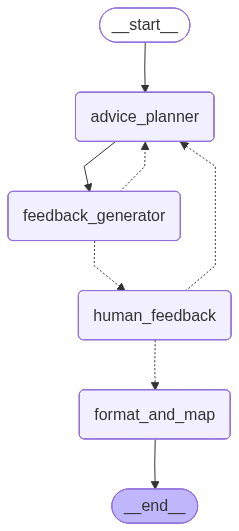

In [66]:
builder = StateGraph(state_schema=AdvicePlanningState, output_schema=PlanningOutputState)

builder.add_node("advice_planner", advice_planner)
builder.add_node("feedback_generator", feedback_generator)
builder.add_node("human_feedback", human_feedback)
builder.add_node("format_and_map", format_and_map)

builder.add_edge(START, "advice_planner")
builder.add_edge("advice_planner", "feedback_generator")
builder.add_conditional_edges("feedback_generator", continue_planning, ["advice_planner", "human_feedback"])
builder.add_conditional_edges("human_feedback", act_on_feedback, ["format_and_map", "advice_planner"])
builder.add_edge("format_and_map", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
thread = {'configurable' : {"thread_id" : "thread-1"}}
problem = "I'm feeling very stressed at work because I don't like being sorrounded by many people in my office. At the same time I can't work from home."

result = graph.invoke({"problem": problem, "max_steps": 3}, config=thread, stream_mode="values")

# First interrupt
print(result["__interrupt__"][0].value)

user_input = input("\n-----\nProvide your response: ")

result = graph.invoke(Command(resume=user_input), config=thread, stream_mode="values")

# Second interrupt
print(result["__interrupt__"][0].value)

user_input = input("\n-----\nProvide your response: ")

for event in graph.stream(Command(resume=user_input), config=thread, stream_mode="values"):
    steps =  event.get("steps", "")
    if steps:
        print("\n" + "-" * 10)
        for step in steps:
            print(step.step_summary)
            print("\n\n---\n\n")




Do you have any feedback for the current version of the wellbeing action plan? Type 'No feedback' if none.

Plan:

Here is the improved wellbeing action plan:

- Step -
Theme: Workplace adjustments
Helpful tip: Consider discussing with your manager the possibility of having a more private workspace or using noise-cancelling headphones to help reduce the stress of being surrounded by many people. Additionally, explore the option of flexible work hours to avoid peak office times when the environment is busier.

- Step -
Theme: Therapy
Helpful tip: Engaging in cognitive-behavioral therapy (CBT) can help you develop coping strategies to manage stress and anxiety related to your work environment. Also, consider seeking support from an Employee Assistance Program (EAP) if available, as it can provide access to counseling services.

- Step -
Theme: Lifestyle changes
Helpful tip: Incorporate mindfulness practices, such as meditation or deep-breathing exercises, into your daily routine to help

In [10]:
# def run_with_multiple_interrupts(graph, initial_input, config):
#     """Run graph with support for multiple interruptions"""
    
#     # Initial invocation
#     result = graph.invoke(initial_input, config=config)
    
#     # Keep processing interruptions until complete
#     while "__interrupt__" in result and result["__interrupt__"]:
#         # Get the interrupt message
#         interrupt_message = result["__interrupt__"][0].value
#         print(interrupt_message)
        
#         # Get user input
#         user_input = input("\n-----\nProvide your response: ")
        
#         # Resume and get new result
#         result = graph.invoke(Command(resume=user_input), config=config)
        
#         # Process any intermediate outputs if needed
#         steps = result.get("steps", "")
#         if steps:
#             for step in steps:
#                 print(step.step_summary)
#                 print("\n\n---\n\n")
    
#     return result

# # Usage
# thread = {'configurable': {"thread_id": "121"}}
# problem = "I'm feeling very stressed at work because I don't like being surrounded by many people in my office."

# final_result = run_with_multiple_interrupts(
#     graph,
#     {"problem": problem, "max_steps": 5},
#     config=thread
# )